# Working Environment

We import all the packages you should need below. However, feel free to import extra packages. If you need to install some of these packages (ex: **rasterio**), you can access your shell and install like this:

```shell
!pip install myPackage
```



```shell
!pip install -e git+https://github.com/scikit-learn/scikit-learn.git
```

In [1]:
!pip install myPackage

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 3.6 MB/s eta 0:00:00
  Created wheel for myPackage: filename=Mypackage-0.1-py3-none-any.whl size=1788 sha256=81d91497eb89ca5c0929fa9ee490f5867a7de144292b0f7b75062fc59b8d0ca3
  Stored in directory: /root/.cache/pip/wheels/3d/88/48/ce4d4150a8633f5f739a2a623348cc717b5d585d71ab427b2f
Successfully built myPackage


In [5]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 53.7 MB/s eta 0:00:00


In [31]:
# All the imports are here
import os
import re
import warnings

import numpy as np
import rasterio
from matplotlib import pyplot as plt

%matplotlib inline

# Data Manipulation Challenge description & instructions

In this challenge, you will have to load and manipulate satellite images, a typical daily task at Kayrros. Data manipulation is one of the core skills one should master, even before thinking about fancy algorithms and data pipelines.

You will not be required to have any specific knowledge on imagery, as we will provide you with the necessary guidelines.

Please keep your code clean and don't forget to comment your code. You are also encouraged to provide as much detail as you can in markdown cells or in comments, even if you have ideas you do not have time to explore. We will evaluate the cleanliness of your code as much as your results.

Have fun!

# Data loading and data description

## Setup

In [32]:
# Define the path where the images are located
IMG_PATH = '/content/data'

# The functions below will be useful to load tif images as arrays
def rio_open(p):
    """
    Open an image with rasterio.

    Args:
        p: path to the image file

    Returns:
        rasterio dataset
    """
    with warnings.catch_warnings():  # noisy warning may occur here
        warnings.filterwarnings("ignore", category=UserWarning)
        return rasterio.open(p)

def rio_read(p):
    """
    Read an image with rasterio.

    Args:
        p: path to the image file

    Returns:
        numpy array
    """
    with rio_open(p) as x:
        return x.read().transpose((1, 2, 0)).squeeze()

## Loading and visualizing your first random satellite image band

Each satellite image is composed of 13 bands, going from visible light to near infrared.

You will find these bands in the `data/` folder, under the format [image\_date]\_[image\_number].tif

The usual RGB images you are used to see (a picture for instance) are made of bands B02 (Blue), B03 (Green) and B04 (Red)

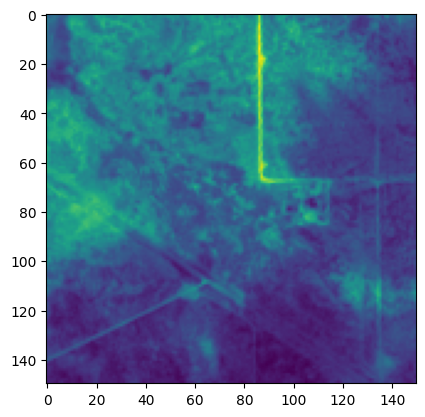

In [33]:
# Here, we show you how to load a given band from a random image and to visualize it
random_image_band = 'data/20170106_B02.tif'
img = rio_read(random_image_band)
plt.imshow(img)

## Loading the data set

In this section, you are expected to load the full data set in the following format: **dataset = {img\_date: {'B01': img\_B01_array, ..., 'B12': img\_B12_array}}**, where img\_B0X_array are the image bands as arrays, i.e. the output of the rio_read() function

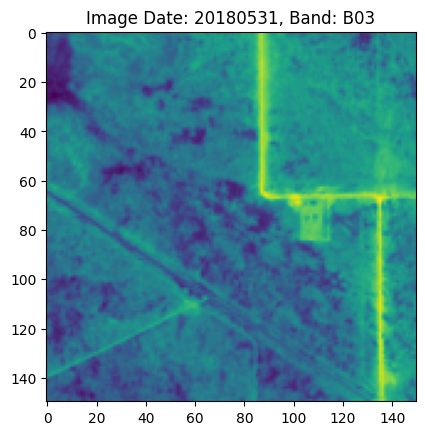

In [36]:
# Initialize the dataset dictionary
dataset = {}

# Iterate over files in the IMG_PATH
for filename in os.listdir(IMG_PATH):
    if filename.endswith(".tif"):
        # Extract date and band from filename
        match = re.match(r"(\d{8})_B(\d{2}).tif", filename)
        if match:
            img_date, band = match.groups()

            # Load the image as an array
            img_path = os.path.join(IMG_PATH, filename)
            img_array = rio_read(img_path)

            # Organize the data in the dataset dictionary
            if img_date not in dataset:
                dataset[img_date] = {}
            dataset[img_date][f"B{band}"] = img_array

# Sanity check: visualize the 3rd band of the image from 2018/05/31
img_date = '20180531'
band = 'B03'

if img_date in dataset and band in dataset[img_date]:
    plt.imshow(dataset[img_date][band])
    plt.title(f"Image Date: {img_date}, Band: {band}")
    plt.show()
else:
    print(f"Image or band not found for date {img_date} and band {band}")

# Generating a RGB image

Now we know how to visualize a given satellite image band, we are going to build a function that will allow us to visualize a given satellite image as an RGB image.

A RGB image can be represented as a 3D array, with the dimensions [channel, img_height, img_width] or [img_height, img_width, channel], with channels B02, B03 and B04.

In [14]:
# In order to test your function, you can use the following random image
# We want to display the image as an RGB composite, i.e. B04, B03, B02
img = np.array([dataset['20170630']['B04'], dataset['20170630']['B03'], dataset['20170630']['B02']])

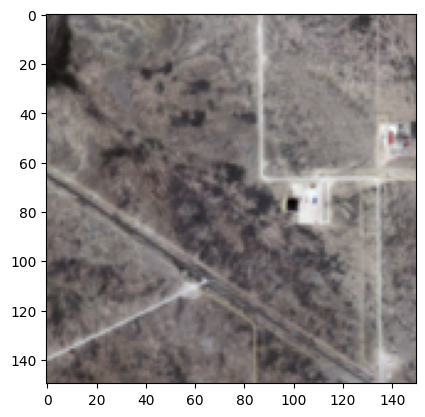

Shape check passed. The returned image has the correct shape: (150, 150, 3)


In [17]:
# Build your function that takes as input, a 3D array with B04, B03, B02 bands and returns the final rgb_img ready to be visualized

# WRITE YOUR CODE HERE by completing the function below



# Function to Generate and Display Normalized RGB Images
def generate_rgb_img(img):
    # Normalize the image
    # Assuming img is a numpy array with shape [channel, height, width]
    normalized_img = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        band = img[i]
        normalized_img[i] = (band - band.min()) / (band.max() - band.min())

    # Reformat the image for imshow()
    # Transpose the dimensions to [height, width, channel]
    rgb_img = np.transpose(normalized_img, (1, 2, 0))

    # Display the RGB image
    plt.imshow(rgb_img)
    plt.show()

    return rgb_img



# Sanity check: test your function
# Test the function with the provided img array
rgb_image = generate_rgb_img(img)

# Check if the returned image has the correct shape
expected_shape = (img.shape[1], img.shape[2], 3)  # (height, width, 3 channels)
actual_shape = rgb_image.shape

if actual_shape == expected_shape:
    print("Shape check passed. The returned image has the correct shape:", actual_shape)
else:
    print("Shape check failed. Expected shape:", expected_shape, "but got:", actual_shape)

# Detecting patterns in satellite imagery: flaring detection
In this section, we are going to detect some activity that might be difficult to observe in an RGB image by utilizing other satellite bands.

The activity we want to detect is called flaring: the process of burning gas in an open flame, which can be detected easily in the infrared spectrum picked up by the satellite.

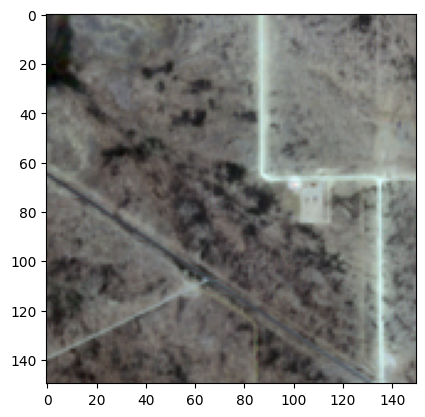

In [28]:
# Load and visualize the RGB image on 2018/05/31
date = '20180531'
rgb_img = generate_rgb_img(np.array([dataset[date]['B04'], dataset[date]['B03'], dataset[date]['B02']]))

**Question**: Can you easily identify flaring in this image?

**Answer**: To some degree, I can see the flaring, but it may not be immediately visible to an untrained eye.




In [37]:
# You can generate a heatmap by simply adding B11 and B12, that is to say: heatmap = B11 + B12
# Below, generate a heatmap of the image and visualize it. You should see a clear signal on the center-right of the image

# Generate a heatmap by adding B11 and B12
heatmap = dataset[date]['B11'] + dataset[date]['B12']

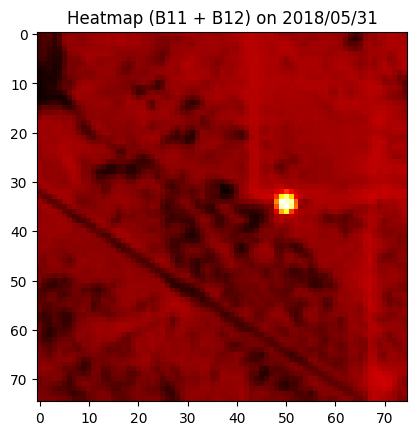

In [20]:
# To help us automate the detection process, it is easier to produce a mask of the flaring activity
# We can consider that there is flaring activity on a pixel if the value of the pixel is above 15,000
# Generate a mask of the flaring activity in the previous heatmap (mask: pixel=1 where there is flaring, pixel=0 where there is no flaring)
# Visualize the resulting mask


# Visualize the heatmap
plt.imshow(heatmap, cmap='hot')
plt.title("Heatmap (B11 + B12) on 2018/05/31")
plt.show()

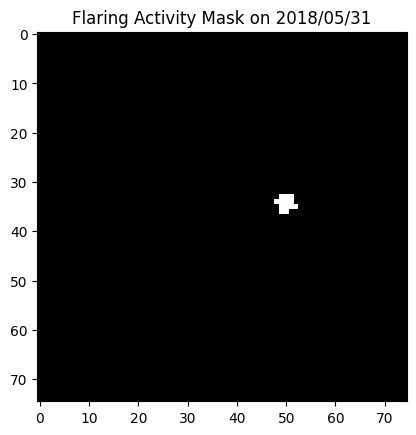

Dates with detected flaring activity: ['20180725', '20180531', '20180625', '20180317', '20180615', '20180804', '20180715', '20180620', '20170307', '20170903', '20180730', '20180809', '20180302', '20171102']


In [21]:
# We consider an image to have flaring activity if the number of pixels above 15.000 in an image is >= 5.
# Write below a function that returns all the dates for which we should detect flaring activity in the data we provided



# Generate a mask of the flaring activity
flaring_threshold = 15000
flaring_mask = heatmap > flaring_threshold


# Visualize the resulting mask
plt.imshow(flaring_mask, cmap='gray')
plt.title("Flaring Activity Mask on 2018/05/31")
plt.show()


# Function to detect dates with flaring activity
def detect_flaring_dates(dataset, threshold=15000, min_flaring_pixels=5):
    flaring_dates = []
    for date, bands in dataset.items():
        heatmap = bands['B11'] + bands['B12']
        flaring_activity = np.sum(heatmap > threshold)
        if flaring_activity >= min_flaring_pixels:
            flaring_dates.append(date)
    return flaring_dates

# Detect flaring dates
detected_dates = detect_flaring_dates(dataset)
print("Dates with detected flaring activity:", detected_dates)

**Question:** if you had 1,000 images to process, would you keep the same code structure? What would you change?

**Answer**: For processing a large number of images, such as 1,000, I would make several improvements to the current code structure. I would introduce parallel processing techniques to reduce overall processing time, Also, instead of loading all images into memory at once, a more memory-efficient way would be to process images in batches or use lazy loading techniques, especially if the images are large.

# More fun on data manipulation: zooming in an image on the flaring activity detected

In [38]:
# First, find the center of the flaring activity, that is to say, given all the images for which you detected that there was a flare,
# combine them to find the center of the flaring activity in the image time series
# Your code should return the index of the pixel at the center of the flaring activity



# Function to Calculate the Center of Flaring Activity
def find_flaring_center(dataset, detected_dates):
    flaring_sum = None  # Initialize a variable for accumulating flaring positions

    for date in detected_dates:
        heatmap = dataset[date]['B11'] + dataset[date]['B12']  # Combine B11 and B12 bands to create a heatmap
        flaring_mask = heatmap > 15000  # Identify flaring areas in the heatmap

        if flaring_sum is None:
            flaring_sum = np.zeros_like(flaring_mask, dtype=int)  # Initialize flaring_sum in the first iteration

        flaring_sum += flaring_mask  # Accumulate flaring areas over all dates

    # Find the average coordinates of flaring pixels
    y, x = np.where(flaring_sum)
    center_y, center_x = np.mean(y), np.mean(x)

    return int(center_x), int(center_y)  # Return the center coordinates as integers

# Calculate the center of flaring activity
flaring_center = find_flaring_center(dataset, detected_dates)
print("Center of Flaring Activity:", flaring_center)

Center of Flaring Activity: (56, 32)


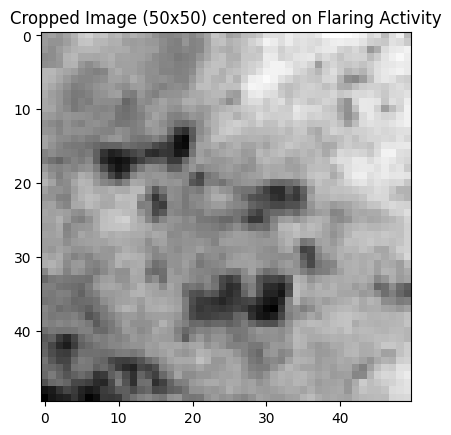

In [24]:
# Then, make a crop of band B02 using an image of your choice, centered on the pixel at the center of the flaring activity, with a size of 50 x 50 pixels
# If the crop is not entirely contained in the image, you can complete the missing pixels of the crop with the value 0
# Do not use any pre-built cropping functions from other libraries, only use umpy array manipulation.
# Visualize the crop



#Function for Cropping an Image Around a Specified Center Point
def crop_image(image, center, size=50, fill_value=0):
    height, width = image.shape  # Get the dimensions of the original image
    x, y = center  # Center coordinates for cropping
    half_size = size // 2  # Half of the desired crop size

    # Calculate the boundaries of the crop
    left, right = max(x - half_size, 0), min(x + half_size, width)
    top, bottom = max(y - half_size, 0), min(y + half_size, height)

    # Initialize a blank image with the specified fill value
    cropped_image = np.full((size, size), fill_value, dtype=image.dtype)

    # Place the cropped section into the initialized image
    cropped_image[0:(bottom-top), 0:(right-left)] = image[top:bottom, left:right]

    return cropped_image  # Return the cropped image

# Use the function to crop an image around the flaring center
chosen_date = detected_dates[0]
chosen_image = dataset[chosen_date]['B02']
cropped_img = crop_image(chosen_image, flaring_center)

# Visualize the cropped image
plt.imshow(cropped_img, cmap='gray')
plt.title(f"Cropped Image (50x50) centered on Flaring Activity")
plt.show()

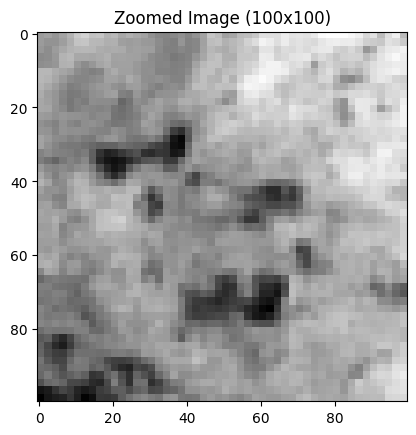

In [41]:
# Finally, zoom (expand the size) of the previously obtained crop, i.e. produce an image of size 100x100 pixels from the crop of size 50x50
# Do not use any pre-built functions from other libraries
# For this, you will have to create "new" pixels, that you can either interpolate or duplicate from neighboring existing pixels
# Visualize the resulting image



# Function to Manually Zoom an Image to a Specified Size
def zoom_image(image, new_img_size):
    height, width = image.shape  # Get the dimensions of the original image
    zoomed_img = np.zeros((new_img_size, new_img_size), dtype=image.dtype)  # Initialize a blank image for the zoomed result

    for i in range(new_img_size):
        for j in range(new_img_size):
            # Map each pixel in the new image to its corresponding pixel in the original image
            original_i, original_j = int(i * height / new_img_size), int(j * width / new_img_size)
            zoomed_img[i, j] = image[original_i, original_j]  # Assign pixel values from the original image

    return zoomed_img  # Return the zoomed image

# Zoom the cropped image to 100x100
zoomed_img = zoom_image(cropped_img, 100)

# Visualize the zoomed image
plt.imshow(zoomed_img, cmap='gray')
plt.title("Zoomed Image (100x100)")
plt.show()

CONGRATS ! You made it. We hope you had fun, please send back your solution in due time.